In [1]:
import sys
# !{sys.executable} -m pip install tldextract

<div style='text-align:center;'>
<h1>BioPortal</h1>
</div>

In [2]:
__author__ = "Lisette Espin-Noboa"
__copyright__ = "Copyright 2018, HopRank"
__credits__ = ["Florian Lemmerich", "Markus Strohmaier", "Simon Walk", "Mark Musen"]
__license__ = "GPL"
__version__ = "1.0.3"
__maintainer__ = "Lisette Espin-Noboa"
__email__ = "Lisette.Espin@gesis.org"
__status__ = "Developing"

########################################################################################
# Warnings
########################################################################################
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

<h2>Dependencies</h2>

In [3]:
########################################################################################
# System
########################################################################################
import os
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt 
from collections import defaultdict

########################################################################################
# Local Dependencies
########################################################################################
%reload_ext autoreload
%autoreload 2
from org.gesis.libs.bioportal.ontology import Ontology
from org.gesis.libs.bioportal.transition import Transition
from org.gesis.libs.bioportal.clickstream import NAVITYPES
from org.gesis.libs.bioportal.clickstream import load_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_sessions
from org.gesis.libs.bioportal.clickstream import clean_clickstream
from org.gesis.libs.bioportal.submission import get_submissions
from org.gesis.libs.utils import log
from org.gesis.libs.utils import weighted_to_undirected


<h2>Constants</h2>

In [4]:
SM = 'submission'
SUBMISSIONS_FN = '/bigdata/lespin/datasets/bioportal/submissions.json'

ON = 'ontology'
ONTOLOGY_ROOT = '/bigdata/lespin/datasets/bioportal/ontologies'
ONTOLOGY_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/ontologies/graph'
ONTOLOGY_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/ontologies/matrix'
ONTOLOGY_NODES_OUTPUT = '/bigdata/lespin/bioportal/ontologies/nodes'

CS = 'clickstream'
CS_FN = 'BP_webpage_requests_<YEAR><POSTFIX>.csv.bz2'
CLICKSTREAM_ROOT = '/bigdata/lespin/datasets/bioportal/clickstream/'
CLICKSTREAM_DF = '/bigdata/lespin/bioportal/clickstreams'

TR = 'transitions'
TRANS_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/transitions/graph'
TRANS_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/transitions/matrix'
TRANS_NODES_OUTPUT = '/bigdata/lespin/bioportal/transitions/nodes'

SU = 'summary'
LOG_OUTPUT = '/bigdata/lespin/bioportal/logs'
PLOTS_OUTPUT = '/bigdata/lespin/bioportal/plots'
SUMMARY_OUTPUT = '/bigdata/lespin/bioportal/summary'
YEAR = '2015'

LAG_BREAK_IN_MINUTES = 60
MIN_SESSION_LENGTH = 2
MIN_REQ = 1000
MIN_TRANSITIONS = 1000

<div style='text-align:center;'>
<h1>Submissions</h1>
</div>

In [5]:
%%capture cap --no-stderr
submissions_dict = get_submissions(SUBMISSIONS_FN)

In [6]:
print(cap.stdout)
log(LOG_OUTPUT, SM, cap)
del(cap)

2019-01-28 19:31:27	/bigdata/lespin/datasets/bioportal/submissions.json loaded!
2019-01-28 19:31:27	- 642 ontologies
2019-01-28 19:31:27	- 13 years

2019-01-28 19:31:27	/bigdata/lespin/bioportal/logs/submission_2019-01-28_19.log saved!


<div style='text-align:center;'>
<h1>Clickstreams</h1>
</div>

<h2>1. Loading Clickstream (raw)</h2>

In [7]:
%%capture cap --no-stderr
clickstreams = load_clickstream(CLICKSTREAM_ROOT, YEAR)

In [8]:
print(cap.stdout)
log(LOG_OUTPUT, CS, cap)
del(cap)

2019-01-28 19:33:16	/bigdata/lespin/datasets/bioportal/clickstream/BP_webpage_requests_2015.csv.bz2 loaded!

2019-01-28 19:33:16	/bigdata/lespin/bioportal/logs/clickstream_2019-01-28_19.log saved!


In [9]:
clickstreams.head()

,Unnamed: 0,timestamp,req_id,ip,action,request,request_action,statuscode,size,referer,useragent,ontology,concept
0,0,2015-01-01 00:00:23,26123018,155.94.218.175,GET,/ontologies/ICD9CM/classes/176,Browse Ontology Class,301.0,142.0,http://purl.bioontology.org/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,ICD9CM,NaN
1,1,2015-01-01 00:00:24,26123019,155.94.218.175,GET,/ontologies/ICD9CM?p=classes&conceptid=176,Browse Ontology Class,500.0,2073.0,http://purl.bioontology.org/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,ICD9CM,176
2,2,2015-01-01 00:00:27,26123020,155.94.218.175,GET,/help,Browse Help,200.0,8644.0,http://bioportal.bioontology.org/ontologies/IC...,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,NAN,NaN
3,3,2015-01-01 00:01:18,35315115,50.18.157.78,GET,/ontologies/1341?apikey=25503fcd-f8e2-4f3f-90e...,Ontology Summary,301.0,157.0,http://localhost:4444/selenium-server/core/Bla...,Mozilla/5.0 (X11; Linux i686; rv:10.0) Gecko/2...,1341,NaN
4,4,2015-01-01 00:01:18,35315116,50.18.157.78,GET,/ontologies/COSTART?apikey=25503fcd-f8e2-4f3f-...,Ontology Summary,200.0,6257.0,http://localhost:4444/selenium-server/core/Bla...,Mozilla/5.0 (X11; Linux i686; rv:10.0) Gecko/2...,COSTART,NaN


<h2>2. Pre-processing Clickstream</h2>
<h3>2.1. Parsing: inferring ontology/concept/navitype</h3>

In [10]:
%%capture cap --no-stderr
clickstreams = preprocess_clickstream(clickstreams)

In [11]:
print(cap.stdout)
log(LOG_OUTPUT, CS, cap)
del(cap)


2019-01-28 20:06:03	/bigdata/lespin/bioportal/logs/clickstream_2019-01-28_20.log saved!


In [12]:
clickstreams.head()

,Unnamed: 0,timestamp,req_id,ip,action,request,request_action,statuscode,size,referer,useragent,ontology,concept,_ontology,_concept,_navitype,_request
0,0,2015-01-01 00:00:23,26123018,155.94.218.175,GET,/ontologies/ICD9CM/classes/176,Browse Ontology Class,301.0,142.0,http://purl.bioontology.org/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,ICD9CM,NaN,ICD9CMCLASSES176,NaN,O,/ontologies/ICD9CM/classes/176
1,1,2015-01-01 00:00:24,26123019,155.94.218.175,GET,/ontologies/ICD9CM?p=classes&conceptid=176,Browse Ontology Class,500.0,2073.0,http://purl.bioontology.org/,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,ICD9CM,176,ICD9CM,176,EL,/ontologies/ICD9CM?p=classes&conceptid=176
2,2,2015-01-01 00:00:27,26123020,155.94.218.175,GET,/help,Browse Help,200.0,8644.0,http://bioportal.bioontology.org/ontologies/IC...,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,NAN,NaN,HELP,NaN,O,/help
3,3,2015-01-01 00:01:18,35315115,50.18.157.78,GET,/ontologies/1341?apikey=25503fcd-f8e2-4f3f-90e...,Ontology Summary,301.0,157.0,http://localhost:4444/selenium-server/core/Bla...,Mozilla/5.0 (X11; Linux i686; rv:10.0) Gecko/2...,1341,NaN,1341,NaN,O,/ontologies/1341?apikey=25503fcd-f8e2-4f3f-90e...
4,4,2015-01-01 00:01:18,35315116,50.18.157.78,GET,/ontologies/COSTART?apikey=25503fcd-f8e2-4f3f-...,Ontology Summary,200.0,6257.0,http://localhost:4444/selenium-server/core/Bla...,Mozilla/5.0 (X11; Linux i686; rv:10.0) Gecko/2...,COSTART,NaN,COSTART,NaN,O,/ontologies/COSTART?apikey=25503fcd-f8e2-4f3f-...


In [13]:
fn = CS_FN.replace('<YEAR>',YEAR).replace('<POSTFIX>','_parsed')
fn = os.path.join(CLICKSTREAM_DF,fn)
if os.path.exists(fn):
    print('loading...')
    clickstreams = pd.read_csv(fn, compression='bz2')
    print('{} loaded!'.format(fn))
else:
    print('saving...')
    clickstreams.to_csv(fn, compression='bz2')
    print('{} saved!'.format(fn))

loading...


/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/bigdata/lespin/bioportal/clickstreams/BP_webpage_requests_2015_parsed.csv.bz2 loaded!


<h3>2.2. Lag Distribution</h3>

In [14]:
tmp = clickstreams.copy()
tmp.timestamp = pd.to_datetime(tmp.timestamp)
tmp['lag'] = tmp.sort_values(['ip','timestamp']).groupby('ip')['timestamp'].diff()
tmp = tmp.dropna(subset=['lag'])
tmp.loc[:,'lag_seconds'] = pd.to_numeric(tmp.lag)/1000000000
tmp.loc[:,'lag_minutes'] = tmp.lag_seconds / 60.
tmp.query('_navitype != "O" ')[['lag','lag_seconds','lag_minutes']].describe()

,lag,lag_seconds,lag_minutes
count,1319398,1.319398e+06,1.319398e+06
mean,0 days 10:23:27.529966,3.740753e+04,6.234588e+02
std,6 days 19:00:34.701450,5.868347e+05,9.780578e+03
min,0 days 00:00:00,0.000000e+00,0.000000e+00
25%,0 days 00:00:00,0.000000e+00,0.000000e+00
50%,0 days 00:00:02,2.000000e+00,3.333333e-02
75%,0 days 00:00:08,8.000000e+00,1.333333e-01
max,350 days 06:46:06,3.026437e+07,5.044061e+05


In [15]:
tmp.query('_navitype != "O" & lag_seconds < 86400').groupby('lag').size().reset_index()

,lag,0
0,00:00:00,353639
1,00:00:01,286474
2,00:00:02,106840
3,00:00:03,75082
4,00:00:04,54543
5,00:00:05,42028
6,00:00:06,33183
7,00:00:07,26633
8,00:00:08,22088
9,00:00:09,18408


P(x <= 15 min): 0.985%
P(x <= 30 min): 0.99%
P(x <= 60 min): 0.995%


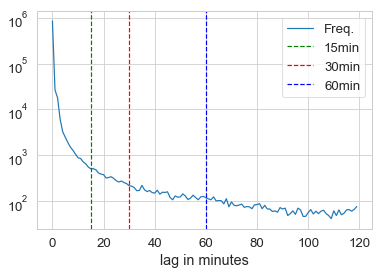

/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


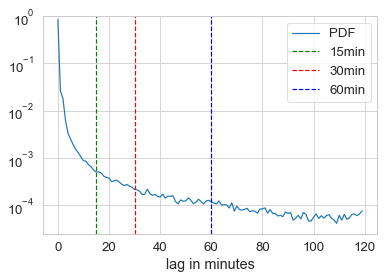

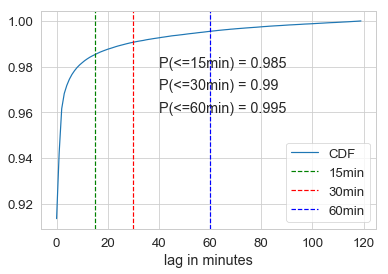

<Figure size 432x288 with 0 Axes>

In [16]:
########################################################
# PLOTTING
########################################################
def plot(y,label,fn,xlog=True,ylog=True,ylim=None,xlim=None,a=None,b=None,c=None,xtext=None):
    to_minutes = 1 / 60.
    sns.set_context(context="paper", font_scale=1.5)
    sns.set_style("whitegrid")
    
    x=np.arange(len(y))
    ax = plt.plot(x, y, label=label)
    
    plt.axvline(x=900* to_minutes, color='green', label='15min', linestyle='--')
    plt.axvline(x=1800* to_minutes, color='red', label='30min', linestyle='--')
    plt.axvline(x=3600* to_minutes, color='blue', label='60min', linestyle='--')
    plt.xlabel('lag in minutes')
        
    if a is not None and b is not None and c is not None and xtext is not None:
        plt.text(x=xtext,y=a, s='P(<={}min) = {}'.format(15,round(y[15-1],3)))
        plt.text(x=xtext,y=b, s='P(<={}min) = {}'.format(30,round(y[30-1],3)))
        plt.text(x=xtext,y=c, s='P(<={}min) = {}'.format(60,round(y[60-1],3)))

    if ylog: plt.yscale('log')
    if xlog: plt.xscale('log')
        
    if ylim is not None: plt.ylim(ylim)
    if xlim is not None: plt.xlim(xlim)
        
    plt.legend()    
    plt.savefig(fn)
    plt.show()
    plt.clf()
    
    
########################################################
# DATA
########################################################
all_lags = False
if all_lags:
    # all
    data_minutes = tmp.query('_navitype != "O" ').lag_minutes
    num_bins = 505440
    a,b,c=0.96,0.95,0.94
    xlog=True
    xtext=100
else:
    # first 2 hours
    data_minutes = tmp.query('_navitype != "O" ').query('lag_seconds > 0 & lag_seconds < 7200').lag_minutes
    num_bins = 120
    a,b,c=0.98,0.97,0.96
    xtext=40
    xlog=False

freq = np.bincount(data_minutes.astype(np.int))
pdf = freq / data_minutes.sum()
cdf = np.cumsum(freq) / float(freq.sum())

print('P(x <= 15 min): {}%'.format(round((cdf/cdf[-1])[15-1],3)))
print('P(x <= 30 min): {}%'.format(round((cdf/cdf[-1])[30-1],3)))
print('P(x <= 60 min): {}%'.format(round((cdf/cdf[-1])[60-1],3)))

fn = os.path.join(PLOTS_OUTPUT,'lag_distribution_in_minutes_{}_freq.pdf'.format('all' if all_lags else 'first2hours'))
plot(freq, 'Freq.', fn, xlog=xlog)

fn = os.path.join(PLOTS_OUTPUT,'lag_distribution_in_minutes_{}_pdf.pdf'.format('all' if all_lags else 'first2hours'))
plot(pdf, 'PDF',fn, xlog=xlog,ylim=[0,1])

fn = os.path.join(PLOTS_OUTPUT,'lag_distribution_in_minutes_{}_cdf.pdf'.format('all' if all_lags else 'first2hours'))
plot(cdf, 'CDF',fn,a=a,b=b,c=c,xtext=xtext,xlog=xlog,ylog=False)



<h3>2.3. Assigning Sessions</h3>

In [17]:
%%capture cap --no-stderr
LAG_BREAK_IN_MINUTES=60
clickstreams = preprocess_sessions(clickstreams, LAG_BREAK_IN_MINUTES)

In [18]:
print(cap.stdout)
log(LOG_OUTPUT, CS, cap)
del(cap)


2019-01-28 20:11:21	/bigdata/lespin/bioportal/logs/clickstream_2019-01-28_20.log saved!


In [19]:
clickstreams.head()

,Unnamed: 0,Unnamed: 0.1,timestamp,req_id,ip,action,request,request_action,statuscode,size,referer,useragent,ontology,concept,_ontology,_concept,_navitype,_request,_sessionid,_year
3541990,3541980,3541980.0,2015-07-08 08:31:17,20296651.0,1.0.136.11,GET,/ontologies/SNOMEDCT/classes/113298000,Browse Ontology Class,301.0,151.0,-,Mozilla/5.0 (iPad; CPU OS 8_1_2 like Mac OS X)...,SNOMEDCT,NaN,SNOMEDCTCLASSES113298000,NaN,O,/ontologies/SNOMEDCT/classes/113298000,1,2015.0
3541993,3541983,3541983.0,2015-07-08 08:31:18,20296652.0,1.0.136.11,GET,/ontologies/SNOMEDCT?p=classes&conceptid=11329...,Browse Ontology Class,200.0,7814.0,-,Mozilla/5.0 (iPad; CPU OS 8_1_2 like Mac OS X)...,SNOMEDCT,113298000,SNOMEDCT,113298000,DU,/ontologies/SNOMEDCT?p=classes&conceptid=11329...,1,2015.0
4067068,4067058,4067058.0,2015-12-30 08:41:59,20296663.0,1.0.184.237,GET,/ontologies/RCD,Ontology Summary,200.0,9083.0,http://bioportal.bioontology.org/,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,RCD,NaN,RCD,NaN,O,/ontologies/RCD,2,2015.0
4035162,4035152,4035152.0,2015-12-23 08:16:49,20296664.0,1.0.186.30,GET,/resource_index,Browse Resource Index,200.0,558983.0,http://bioportal.bioontology.org/,Mozilla/5.0 (Windows NT 6.1; rv:34.0) Gecko/20...,NAN,NaN,RESOURCE_INDEX,NaN,O,/resource_index,3,2015.0
3974841,3974831,3974831.0,2015-12-18 09:50:46,20296665.0,1.0.187.201,GET,/projects/sparepart,Browse Project,200.0,4472.0,http://bioportal.bioontology.org/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...,NAN,NaN,PROJECTSSPAREPART,NaN,O,/projects/sparepart,4,2015.0


In [20]:
fn = CS_FN.replace('<YEAR>',YEAR).replace('<POSTFIX>','_parsed_sessions')
fn = os.path.join(CLICKSTREAM_DF,fn)
clickstreams.to_csv(fn, compression='bz2')

<h3>2.4. Extracting only valid Requests (and setting sequence within session)</h3>
<ul>
<li>Valid HTTP request: statuscode=200</li>
<li>Valid Navitype: DC, DE, EX, LS, DU, EL, ES, HS</li>
<li>Request to a non-empty ontology and non-empty concept</li>
</ul>

In [21]:
%%capture cap --no-stderr
valid_clickstreams = clean_clickstream(clickstreams)

In [22]:
print(cap.stdout)
log(LOG_OUTPUT, CS, cap)
del(cap)


2019-01-28 20:22:53	/bigdata/lespin/bioportal/logs/clickstream_2019-01-28_20.log saved!


In [23]:
valid_clickstreams.head()

,original_id,Unnamed: 0.1,timestamp,req_id,ip,action,request,request_action,statuscode,size,...,useragent,ontology,concept,_ontology,_concept,_navitype,_request,_sessionid,_year,_sequence
0,3541983,3541983.0,2015-07-08 08:31:18,20296652.0,1.0.136.11,GET,/ontologies/SNOMEDCT?p=classes&conceptid=11329...,Browse Ontology Class,200.0,7814.0,...,Mozilla/5.0 (iPad; CPU OS 8_1_2 like Mac OS X)...,SNOMEDCT,113298000,SNOMEDCT,113298000,DU,/ontologies/SNOMEDCT?p=classes&conceptid=11329...,1,2015.0,1
1,1049578,1049578.0,2015-02-24 08:49:06,20296672.0,1.0.206.131,GET,/ajax_concepts/CPT/?conceptid=http%3A%2F%2Fpur...,Browse Ontology Class,200.0,2297.0,...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,CPT,http://purl.bioontology.org/ontology/CPT/1005780,CPT,1005780,DC,/ajax_concepts/CPT/?conceptid=http://purl.bioo...,8,2015.0,2
2,1049579,1049579.0,2015-02-24 08:49:11,20296680.0,1.0.206.131,GET,/ajax_concepts/CPT/?conceptid=http%3A%2F%2Fpur...,Browse Ontology Class Tree,200.0,268.0,...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,CPT,http://purl.bioontology.org/ontology/CPT/1005780,CPT,1005780,EX,/ajax_concepts/CPT/?conceptid=http://purl.bioo...,8,2015.0,3
3,1049585,1049585.0,2015-02-24 08:49:19,20296681.0,1.0.206.131,GET,/ajax_concepts/CPT/?conceptid=http%3A%2F%2Fpur...,Browse Ontology Class,200.0,2634.0,...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,CPT,http://purl.bioontology.org/ontology/CPT/1005781,CPT,1005781,DC,/ajax_concepts/CPT/?conceptid=http://purl.bioo...,8,2015.0,4
4,1049586,1049586.0,2015-02-24 08:49:25,20296695.0,1.0.206.131,GET,/ajax_concepts/CPT/?conceptid=http%3A%2F%2Fpur...,Browse Ontology Class Tree,200.0,220.0,...,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,CPT,http://purl.bioontology.org/ontology/CPT/1005781,CPT,1005781,EX,/ajax_concepts/CPT/?conceptid=http://purl.bioo...,8,2015.0,5


In [24]:
fn = CS_FN.replace('<YEAR>',YEAR).replace('<POSTFIX>','_parsed_sessions_prevalid')
fn = os.path.join(CLICKSTREAM_DF,fn)
valid_clickstreams.to_csv(fn, compression='bz2')

<h3>2.4. Summaries</h3>

In [25]:
valid_clickstreams.sample(5)

,original_id,Unnamed: 0.1,timestamp,req_id,ip,action,request,request_action,statuscode,size,...,useragent,ontology,concept,_ontology,_concept,_navitype,_request,_sessionid,_year,_sequence
733336,1973920,1973920.0,2015-04-08 04:54:37,33555636.0,219.73.20.124,GET,/ontologies/RXNORM?p=classes&conceptid=http%3A...,Browse Ontology Class,200.0,7258.0,...,Mozilla/5.0 (iPhone; CPU iPhone OS 8_2 like Ma...,RXNORM,http://purl.bioontology.org/ontology/RXNORM/10...,RXNORM,1046375,ES,/ontologies/RXNORM?p=classes&conceptid=http://...,286391,2015.0,733337
694868,2283122,2283122.0,2015-04-27 04:49:47,32759709.0,208.64.29.250,GET,/ontologies/CPT?p=classes&conceptid=http%3A%2F...,Browse Ontology Class,200.0,7314.0,...,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,CPT,http://purl.bioontology.org/ontology/CPT/88367,CPT,88367,DU,/ontologies/CPT?p=classes&conceptid=http://pur...,266432,2015.0,694869
802026,3386147,3386147.0,2015-06-27 11:31:28,34834580.0,45.43.193.187,GET,/ontologies/SNOMEDCT?p=classes&conceptid=5892005,Browse Ontology Class,200.0,7869.0,...,Mozilla/5.0 (iPhone; CPU iPhone OS 8_1_2 like ...,SNOMEDCT,5892005,SNOMEDCT,5892005,EL,/ontologies/SNOMEDCT?p=classes&conceptid=5892005,323109,2015.0,802027
1249762,3207593,3207593.0,2015-06-21 02:05:24,39829430.0,76.218.120.34,GET,/ontologies/RCD?p=classes&conceptid=http%3A%2F...,Browse Ontology Class,200.0,7461.0,...,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:38.0) G...,RCD,http://purl.bioontology.org/ontology/RCD/X76IV,RCD,x76iv,ES,/ontologies/RCD?p=classes&conceptid=http://pur...,457017,2015.0,1249763
515346,3709756,3709756.0,2015-11-08 14:57:47,29760638.0,188.211.92.54,GET,/ajax_concepts/CHEBI/?conceptid=http%3A%2F%2Fp...,Browse Ontology Class Tree,200.0,218.0,...,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,CHEBI,http://purl.obolibrary.org/obo/CHEBI_63061,CHEBI,chebi_63061,EX,/ajax_concepts/CHEBI/?conceptid=http://purl.ob...,183779,2015.0,515347


In [26]:
%%capture cap --no-stderr
print('{} total records in clickstream {}'.format(len(clickstreams),YEAR))
print('- {} ({}%) pre-valid records'.format(len(valid_clickstreams),round(len(valid_clickstreams)*100/len(clickstreams))))
print('- {} (prevalid) sessions'.format(valid_clickstreams._sessionid.nunique()))
print('- {} (prevalid) ontologies'.format(valid_clickstreams._ontology.nunique()))

In [27]:
print(cap.stdout)
log(LOG_OUTPUT, CS, cap)
del(cap)

4075573 total records in clickstream 2015
- 1269441 (31%) pre-valid records
- 335911 (prevalid) sessions
- 582 (prevalid) ontologies

2019-01-28 20:26:30	/bigdata/lespin/bioportal/logs/clickstream_2019-01-28_20.log saved!


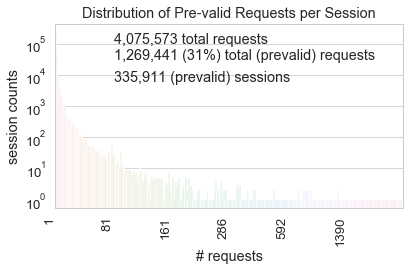

In [28]:
sns.set_context(context="paper", font_scale=1.5)
sns.set_style("whitegrid")
nrequestspersession = pd.DataFrame({'nrequests':valid_clickstreams.groupby(['_sessionid']).size().values})
with sns.color_palette("PuBuGn_d"):
    ax = sns.countplot(x='nrequests',data=nrequestspersession)
    ax.set_yscale('log')
    step=80
    xt = ax.get_xticks()[::step]
    xl = [t.get_text() for t in ax.get_xticklabels()[::step]]
    _ = ax.set_xticks(xt)
    _ = ax.set_xticklabels(xl, rotation=90, ha='right')
    ax.set_title('Distribution of Pre-valid Requests per Session')
    try:
        ax.text(xt[1], 100000, '{:,} total requests'.format(len(clickstreams)))
        ax.text(xt[1], 30000, '{:,} ({}%) total (prevalid) requests'.format(len(valid_clickstreams), round(len(valid_clickstreams)*100/len(clickstreams))))
        ax.text(xt[1], 6000, '{:,} (prevalid) sessions'.format(valid_clickstreams._sessionid.nunique()))
    except:
        pass
    _ = ax.set_ylabel('session counts')
    _ = ax.set_xlabel('# requests')
    plt.tight_layout()

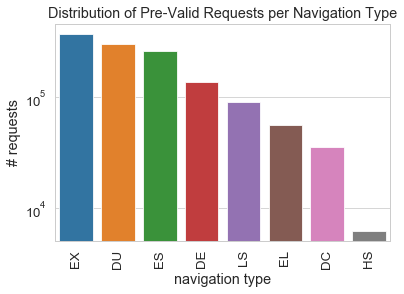

In [29]:
ax = sns.countplot(x='_navitype',
                   data=valid_clickstreams,
                   order=valid_clickstreams['_navitype'].value_counts().index)
ax.set_yscale('log')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribution of Pre-Valid Requests per Navigation Type')
_ = ax.set_ylabel('# requests')
_ = ax.set_xlabel('navigation type')

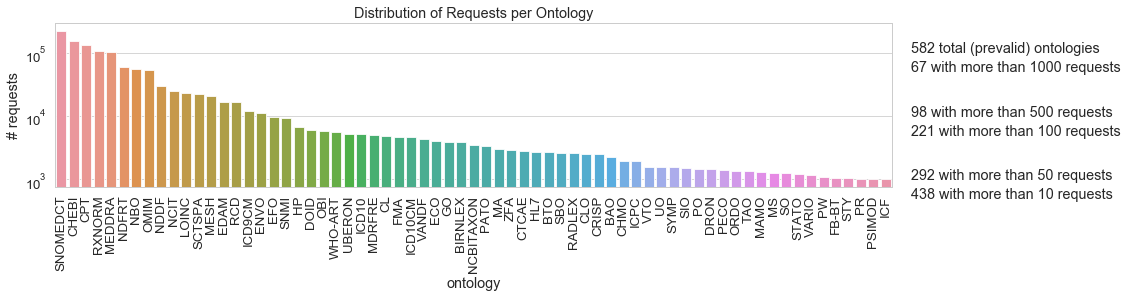

In [30]:
valid_ontologies_clickstream = valid_clickstreams.groupby('_ontology')
m500 = valid_ontologies_clickstream.filter(lambda x: len(x) >= 500)._ontology.nunique()
m100 = valid_ontologies_clickstream.filter(lambda x: len(x) >= 100)._ontology.nunique()
m50 = valid_ontologies_clickstream.filter(lambda x: len(x) >= 50)._ontology.nunique()
m10 = valid_ontologies_clickstream.filter(lambda x: len(x) >= 10)._ontology.nunique()

valid_ontologies_clickstream = valid_ontologies_clickstream.filter(lambda x: len(x) >= MIN_REQ)

fig,ax = plt.subplots(1,1,figsize=(15,3))
_ = sns.countplot(x='_ontology',data=valid_ontologies_clickstream,ax=ax,
                  order=valid_ontologies_clickstream['_ontology'].value_counts().index)
ax.set_yscale('log')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribution of Requests per Ontology')
_ = ax.set_ylabel('# requests')
_ = ax.set_xlabel('ontology')
try:
    nonto = valid_ontologies_clickstream._ontology.nunique()
    ax.text(nonto+1, 100000, '{} total (prevalid) ontologies'.format(valid_clickstreams._ontology.nunique()))
    ax.text(nonto+1, 50000, '{} with more than {} requests'.format(nonto,MIN_REQ))
    ax.text(nonto+1, 10000, '{} with more than {} requests'.format(m500,500))
    ax.text(nonto+1, 5000, '{} with more than {} requests'.format(m100,100))
    ax.text(nonto+1, 1000, '{} with more than {} requests'.format(m50,50))
    ax.text(nonto+1, 500, '{} with more than {} requests'.format(m10,10))
except Exception as ex:
    print(ex)
    pass


<div style='text-align:center;'>
<h1>Ontology</h1>
</div>

In [31]:
%%capture cap --no-stderr
onto_name = 'CPT'
submission = submissions_dict[onto_name][YEAR]
onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
onto.load_ontology()
onto.create_adjacency_matrix()
onto.save_graph(path=ONTOLOGY_GRAPH_OUTPUT)
onto.save_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT)
onto.save_nodes(path=ONTOLOGY_NODES_OUTPUT)

In [32]:
print(cap.stdout)
log(LOG_OUTPUT, ON, cap)
del(cap)

2019-01-28 20:26:55	/bigdata/lespin/datasets/bioportal/ontologies/CPT/6/CPT.csv.gz loaded!
2019-01-28 20:26:58	Convertion CPT-2015 DataFrame to DiGraph done!
2019-01-28 20:26:58	/bigdata/lespin/bioportal/ontologies/graph/CPT_2015.gpickle saved!
2019-01-28 20:26:58	/bigdata/lespin/bioportal/ontologies/matrix/CPT_2015.mtx saved!
2019-01-28 20:26:58	/bigdata/lespin/bioportal/ontologies/nodes/CPT_2015.csv saved!

2019-01-28 20:26:58	/bigdata/lespin/bioportal/logs/ontology_2019-01-28_20.log saved!


<div style='text-align:center;'>
<h1>Transitions by Ontology</h1>
</div>

In [33]:
%%capture cap --no-stderr
navitype = None
cs = Transition(onto_name, navitype, YEAR)
cs.load_clickstream_and_validate(valid_clickstreams,onto.sorted_nodes,MIN_SESSION_LENGTH)
cs.create_adjacency_matrix(sorted_nodes=onto.sorted_nodes)
cs.save_graph(path=TRANS_GRAPH_OUTPUT)
cs.save_adjacency(path=TRANS_ADJACENCY_OUTPUT)
cs.save_nodes(path=TRANS_NODES_OUTPUT)

In [34]:
print(cap.stdout)
log(LOG_OUTPUT, TR, cap)
del(cap)

2019-01-28 20:28:04	CPT-2015-None: 10231 concepts found, but 10075 kept (cros-val)
2019-01-28 20:28:04	/bigdata/lespin/bioportal/transitions/graph/CPT_2015_ALL.gpickle saved!
2019-01-28 20:28:04	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_ALL.mtx saved!
2019-01-28 20:28:04	/bigdata/lespin/bioportal/transitions/nodes/CPT_2015_ALL.csv saved!

2019-01-28 20:28:05	/bigdata/lespin/bioportal/logs/transitions_2019-01-28_20.log saved!


In [35]:
print(nx.info(cs.H))
print(cs.H.size(weight='weight'))
print(onto.A.shape)
print(cs.T.shape)

Name: 
Type: DiGraph
Number of nodes: 10075
Number of edges: 33140
Average in degree:   3.2893
Average out degree:   3.2893
44815.0
(13219, 13219)
(13219, 13219)


<div style='text-align:center; color:red;'>
<h1>All Ontologies & Transitions</h1>
<h2>Cross-validation</h2>
</div>

In [36]:
%%capture cap --no-stderr

transitions = defaultdict(lambda:0)

for onto_name in valid_ontologies_clickstream._ontology.unique():
    ### Onotlogy
    print('\n\n')
    print("***********************************************")
    print(onto_name)
    print("***********************************************")
    try:
        # ontology
        submission = submissions_dict[onto_name][YEAR]
        onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
        onto.load_ontology()
        onto.create_adjacency_matrix()
        onto.save_graph(path=ONTOLOGY_GRAPH_OUTPUT)
        onto.save_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT)
        onto.save_nodes(path=ONTOLOGY_NODES_OUTPUT)
    except Exception as ex:
        onto = None
        print(ex)
    
    ### Transitions per navigation type
    if onto is not None:
        for navitype in [None]+NAVITYPES:
            print("==================")
            print(navitype)
            print("==================")

            try:
                # all transitions
                cs = Transition(onto_name, navitype, YEAR)
                cs.load_clickstream_and_validate(valid_clickstreams,onto.sorted_nodes,MIN_SESSION_LENGTH)            
                cs.create_adjacency_matrix(sorted_nodes=onto.sorted_nodes)
                cs.save_graph(path=TRANS_GRAPH_OUTPUT)
                cs.save_adjacency(path=TRANS_ADJACENCY_OUTPUT)
                cs.save_nodes(path=TRANS_NODES_OUTPUT)

                transitions[navitype] += cs.H.size(weight='weight')
                del(cs)
            except Exception as ex:
                print(ex)
    del(onto)
    print('{} transitions\n'.format(transitions[navitype]))

In [37]:
print(cap.stdout)
log(LOG_OUTPUT, ON, cap)
del(cap)




***********************************************
SNOMEDCT
***********************************************
2019-01-28 20:28:30	/bigdata/lespin/datasets/bioportal/ontologies/SNOMEDCT/11/SNOMEDCT.csv.gz loaded!
2019-01-28 20:30:03	Convertion SNOMEDCT-2015 DataFrame to DiGraph done!
2019-01-28 20:30:14	/bigdata/lespin/bioportal/ontologies/graph/SNOMEDCT_2015.gpickle saved!
2019-01-28 20:30:16	/bigdata/lespin/bioportal/ontologies/matrix/SNOMEDCT_2015.mtx saved!
2019-01-28 20:30:18	/bigdata/lespin/bioportal/ontologies/nodes/SNOMEDCT_2015.csv saved!
None
2019-01-28 20:31:55	SNOMEDCT-2015-None: 51457 concepts found, but 51297 kept (cros-val)
2019-01-28 20:31:59	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_ALL.gpickle saved!
2019-01-28 20:31:59	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_ALL.mtx saved!
2019-01-28 20:32:00	/bigdata/lespin/bioportal/transitions/nodes/SNOMEDCT_2015_ALL.csv saved!
DC
2019-01-28 20:33:54	SNOMEDCT-2015-DC: 6309 concepts found, but 6283 k

In [38]:
transitions

defaultdict(<function __main__.<lambda>()>,
            {'DC': 17677.0,
             'DE': 57683.0,
             'DU': 73608.0,
             'EL': 959.0,
             'ES': 14287.0,
             'EX': 116876.0,
             'HS': 165.0,
             'LS': 64303.0,
             None: 345558.0})

<h2>Plot: # Transitions per navigation type</h2>

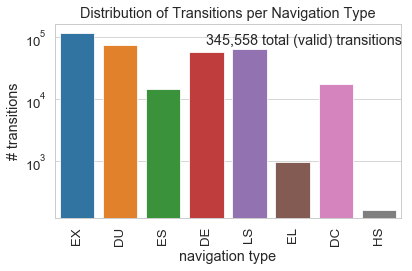

In [39]:
tmp = {}
tmp['navitype'] = NAVITYPES
tmp['ntransitions'] = [transitions[navitype] for navitype in NAVITYPES]
tmp = pd.DataFrame(tmp)
ax = sns.barplot(x='navitype',y='ntransitions',
                   data=tmp,
                   order=valid_clickstreams['_navitype'].value_counts().index)
                   #order=tmp.sort_values('ntransitions', ascending=False)['navitype'])
ax.set_yscale('log')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribution of Transitions per Navigation Type')
_ = ax.set_ylabel('# transitions')
_ = ax.set_xlabel('navigation type')
try:
    id=3
    ax.text(id, tmp.loc[id,'ntransitions'], '{:,} total (valid) transitions'.format(int(transitions[None])))
except:
    pass

plt.tight_layout()
fn = os.path.join(PLOTS_OUTPUT,'summary_navitypes_valid_transitions_{}.pdf'.format(YEAR))
plt.savefig(fn, bbox_inches='tight')


<h2>Validation: Ontologies with at least min # transitions</h2>

In [40]:
%%capture cap --no-stderr
columns = ['ontology','navitype','ntransitions']
df_trans = pd.DataFrame(columns=columns)

for onto_name in valid_ontologies_clickstream._ontology.unique():
    for navitype in NAVITYPES:
        try:
            # all transitions
            cs = Transition(onto_name, navitype, YEAR)            
            cs.load_graph(path=TRANS_GRAPH_OUTPUT)
            
            if cs.H is not None:
                df_trans = df_trans.append({'ontology':onto_name,
                            'navitype':navitype,
                            'ntransitions':cs.H.size(weight='weight')}, ignore_index=True)
            del(cs)
        except Exception as ex:
            print(ex)

In [41]:
print(cap.stdout)
log(LOG_OUTPUT, ON, cap)
del(cap)

2019-01-28 21:47:48	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_DC.gpickle loaded!
2019-01-28 21:47:48	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_DE.gpickle loaded!
2019-01-28 21:47:48	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_EX.gpickle loaded!
2019-01-28 21:47:48	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_DU.gpickle loaded!
2019-01-28 21:47:48	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_LS.gpickle loaded!
2019-01-28 21:47:49	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_ES.gpickle loaded!
2019-01-28 21:47:49	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_EL.gpickle loaded!
2019-01-28 21:47:49	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_HS.gpickle loaded!
2019-01-28 21:47:49	/bigdata/lespin/bioportal/transitions/graph/CPT_2015_DC.gpickle loaded!
2019-01-28 21:47:49	/bigdata/lespin/bioportal/transitions/graph/CPT_2015_DE.gpickle loaded!
2019-01-28 21:47:49	/bigdata/lespin/biop

In [42]:
df_trans.head()

,ontology,navitype,ntransitions
0,SNOMEDCT,DC,5241.0
1,SNOMEDCT,DE,10282.0
2,SNOMEDCT,EX,55174.0
3,SNOMEDCT,DU,23343.0
4,SNOMEDCT,LS,15583.0


In [43]:
sorted_ontos = df_trans.groupby('ontology').ntransitions.sum().reset_index()
sorted_ontos.sort_values('ntransitions', ascending=False, inplace=True)
sorted_ontos

,ontology,ntransitions
17,SNOMEDCT,110859.0
9,MEDDRA,71580.0
1,CPT,44815.0
15,RXNORM,29416.0
13,OMIM,27437.0
12,NDFRT,24662.0
7,LOINC,7905.0
16,SNMI,6091.0
5,ICD9CM,4485.0
10,MESH,3842.0


In [44]:
sorted_valid_ontos = sorted_ontos.query("ntransitions>@MIN_TRANSITIONS")

<h2>Plot: Transitions per navigation type and ontology</h2>

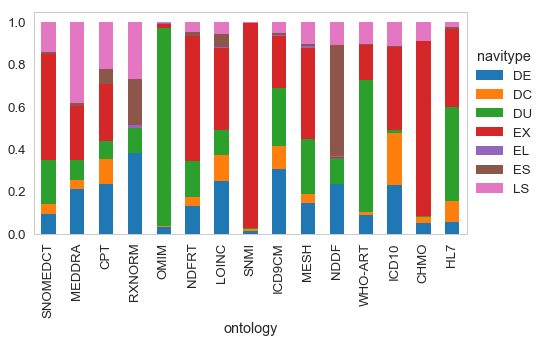

In [45]:
sns.set_style('whitegrid')
navitypes_order = ['DE','DC','DU','EX','EL','ES','LS'] #valid_clickstreams['_navitype'].value_counts().index
tmp = df_trans.pivot(columns='ontology',
               index='navitype',
               values='ntransitions').fillna(0).reindex(index = navitypes_order)[sorted_valid_ontos.ontology]
ax = tmp.divide(tmp.sum(axis=0),axis=1).T.plot.bar(stacked=True, linewidth=0.0, figsize=(7.8,5))
_ = ax.legend(frameon=False, bbox_to_anchor=(1.01,0.5), loc="center left", borderaxespad=0, title='navitype')

ax.grid(False)

plt.tight_layout()
fn = os.path.join(PLOTS_OUTPUT,'summary_navitypes_valid_transitions_per_ontology_{}.pdf'.format(YEAR))
plt.savefig(fn, bbox_inches='tight')


In [46]:
len(sorted_ontos), len(sorted_valid_ontos)

(21, 15)

In [47]:
df_trans.navitype.unique()

array(['DC', 'DE', 'EX', 'DU', 'LS', 'ES', 'EL', 'HS'], dtype=object)

<h2>Summary Table</h2>

In [58]:
from scipy.sparse import csr_matrix
A=csr_matrix(np.array([[0,1,1],[1,0,0],[1,0,0]]))
B=csr_matrix(np.array([[0,0,10],[0,0,10],[10,0,0]]))
# (B.sum(axis=1) > 0).sum()
A.multiply(B>0).sum()

2

In [59]:
columns = ['ontology','N','E','k',"N'","E'","T"]
df_onto = pd.DataFrame(columns=columns)
for onto_name in sorted_valid_ontos.ontology:
    print(onto_name)
    try:
        # ontology
        submission = submissions_dict[onto_name][YEAR]
        onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
        onto.load_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT)
        
        # transitions
        cs = Transition(onto_name, None, YEAR)
        cs.load_adjacency(path=TRANS_ADJACENCY_OUTPUT)        
        
        # visited
        visited = onto.A.multiply(cs.T)
        
        # summary
        df_onto = df_onto.append({'ontology':onto_name,
                       'N':onto.A.shape[0],
                       'E':onto.A.sum(),
                       'k':2*onto.A.sum()/onto.A.shape[0],
                                  
                        "N'": (cs.T.sum(axis=1) > 0).sum() / onto.A.shape[0],
                        "E'": (visited>0).sum() / onto.A.sum(),
                                
                        "T":cs.T.sum()
                  }, ignore_index=True)
        
    except Exception as ex:
        print(ex)
        

SNOMEDCT
2019-01-30 13:34:00	/bigdata/lespin/bioportal/ontologies/matrix/SNOMEDCT_2015.mtx loaded!
2019-01-30 13:34:00	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_ALL.mtx loaded!
MEDDRA
2019-01-30 13:34:03	/bigdata/lespin/bioportal/ontologies/matrix/MEDDRA_2015.mtx loaded!
2019-01-30 13:34:03	/bigdata/lespin/bioportal/transitions/matrix/MEDDRA_2015_ALL.mtx loaded!
CPT
2019-01-30 13:34:04	/bigdata/lespin/bioportal/ontologies/matrix/CPT_2015.mtx loaded!
2019-01-30 13:34:04	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_ALL.mtx loaded!
RXNORM
2019-01-30 13:34:05	/bigdata/lespin/bioportal/ontologies/matrix/RXNORM_2015.mtx loaded!
2019-01-30 13:34:05	/bigdata/lespin/bioportal/transitions/matrix/RXNORM_2015_ALL.mtx loaded!
OMIM
2019-01-30 13:34:05	/bigdata/lespin/bioportal/ontologies/matrix/OMIM_2015.mtx loaded!
2019-01-30 13:34:06	/bigdata/lespin/bioportal/transitions/matrix/OMIM_2015_ALL.mtx loaded!
NDFRT
2019-01-30 13:34:06	/bigdata/lespin/bioportal/ontologies/matrix

/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars


In [60]:
df_onto.reset_index(drop=True,inplace=True)
df_onto.rename(columns={'index':'#'}, inplace=True)
df_onto.loc[:,'#'] = df_onto.index + 1 
df_onto.loc[:,'T'] = df_onto['T'].astype(np.int)
df_onto=df_onto[['#']+columns]
df_onto

,#,ontology,N,E,k,N',E',T
0,1,SNOMEDCT,315684,467027,2.958826,0.149327,0.017556,110859
1,2,MEDDRA,66506,31863,0.958199,0.240505,0.065687,71580
2,3,CPT,13219,13235,2.002421,0.719419,0.224858,44815
3,4,RXNORM,118555,125,0.002109,0.127671,0.024000,29416
4,5,OMIM,81821,39359,0.962076,0.057125,0.003049,27437
5,6,NDFRT,35019,34504,1.970587,0.345898,0.032837,24662
6,7,LOINC,174513,152683,1.749818,0.022067,0.005829,7905
7,8,SNMI,42194,39457,1.870266,0.098023,0.001901,6091
8,9,ICD9CM,22534,22531,1.999734,0.099538,0.025920,4485
9,10,MESH,165166,24182,0.292821,0.012109,0.015301,3842


In [61]:
%%capture cap --no-stderr

fn = os.path.join(SUMMARY_OUTPUT,'summary_ontologies_transitions_{}.{}'.format(YEAR,'csv'))
df_onto.to_csv(fn, index=None)
print('{} saved!'.format(fn))


fn = os.path.join(SUMMARY_OUTPUT,'summary_ontologies_transitions_{}.{}'.format(YEAR,'latex'))
txt = df_onto.to_latex(index=False, float_format=lambda x: '%.2f' % x, bold_rows=[0])
with open(fn, 'w') as f:
    f.write(txt)
    f.write('\n')
print('{} saved!'.format(fn))


In [62]:
print(cap.stdout)
log(LOG_OUTPUT, SU, cap)
del(cap)

/bigdata/lespin/bioportal/summary/summary_ontologies_transitions_2015.csv saved!
/bigdata/lespin/bioportal/summary/summary_ontologies_transitions_2015.latex saved!

2019-01-30 13:34:12	/bigdata/lespin/bioportal/logs/summary_2019-01-30_13.log saved!


In [63]:
df_onto.mean()

#         8.000000
N     72691.133333
E     56662.933333
k         1.458377
N'        0.181554
E'        0.039284
T     22816.333333
dtype: float64